## Loading data

For this example we will use **CamVid** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images have 320 pixels height and 480 pixels width.
For more inforamtion about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [235]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

In [236]:
DATA_DIR = 'VOC2012/ImageSets/Segmentation'

In [237]:
train_dir = os.path.join(DATA_DIR, 'train.txt')
valid_dir = os.path.join(DATA_DIR, 'val.txt')
test_dir = os.path.join(DATA_DIR, 'test.txt')

In [238]:
with open(train_dir, 'r') as fr:
    a = fr.read()
    a = a.split('\n')[:-1]
a[-1]

'2011_003255'

In [253]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

[  0   1  15 255]


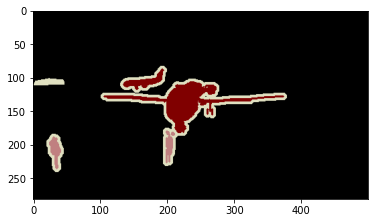

In [240]:
label = Image.open('/data/src/atsushi/segmentation_models.pytorch/examples/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png').convert('P')
# label = cv2.imread('/data/src/atsushi/segmentation_models.pytorch/examples/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png', 0)
print(np.unique(label))
plt.imshow(label)

### Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

In [241]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [283]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['background', 
               'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 
               'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
    
    def __init__(
            self, 
            dataset_txt, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        with open(dataset_txt, 'r') as fr:
            self.ids = fr.read()
            self.ids = self.ids.split('\n')[:-1]  # 最後の要素カラになるので無視

        dirname = os.path.join(*dataset_txt.split('/')[:-3])
        self.images_fps = [os.path.join(dirname, 'JPEGImages', image_id + '.jpg') for image_id in self.ids]
        self.masks_fps = [os.path.join(dirname, 'SegmentationClass', image_id + '.png') for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = Image.open(self.images_fps[i])
        image = np.array(image)
        mask = Image.open(self.masks_fps[i]).convert('P')
        mask = np.array(mask)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            # argmax時にbackgroundを下敷きにする
            mask = np.concatenate((background, mask), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

(281, 500, 3)


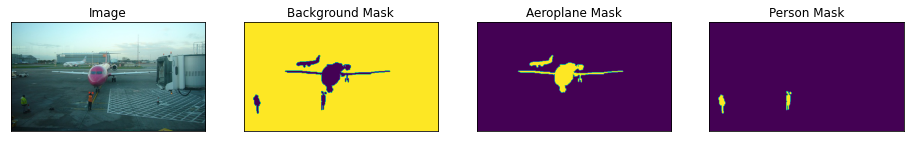

In [284]:
# Lets look at data we have
CLASSES = ['aeroplane', 'person']
dataset = Dataset(train_dir, classes=CLASSES)

image, mask = dataset[0] # get some sample
print(mask.shape)

visualize(
    image=image, 
    background_mask=mask[..., 0].squeeze(),
    aeroplane_mask=mask[..., 1].squeeze(),
    person_mask=mask[..., 2].squeeze(),
#     all_mask=np.argmax(mask, axis=2)
)

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.

In [244]:
import albumentations as albu

In [245]:
def get_training_augmentation():
    train_transform = [
        albu.PadIfNeeded(min_height=256, min_width=256, always_apply=True, border_mode=0),
        albu.RandomCrop(height=224, width=224, always_apply=True),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(min_height=256, min_width=256, always_apply=True, border_mode=0),
        albu.CenterCrop(height=224, width=224, always_apply=True)
    ]
    return albu.Compose(test_transform)


def resize():
    transform = [
        albu.Resize(height=224, width=224)
    ]
    return albu.Compose(transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

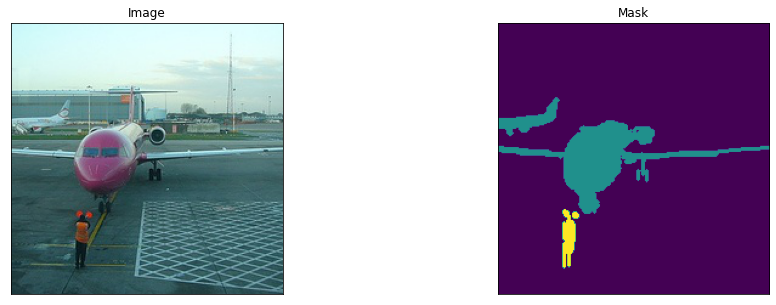

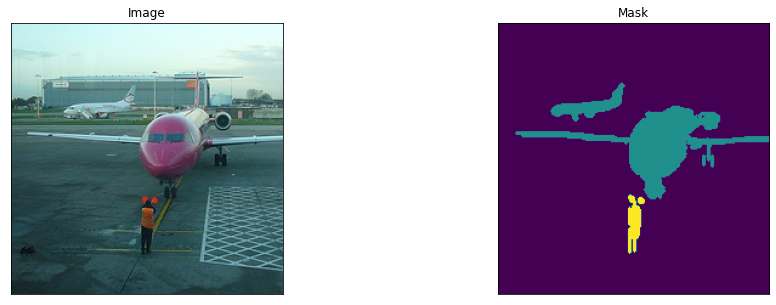

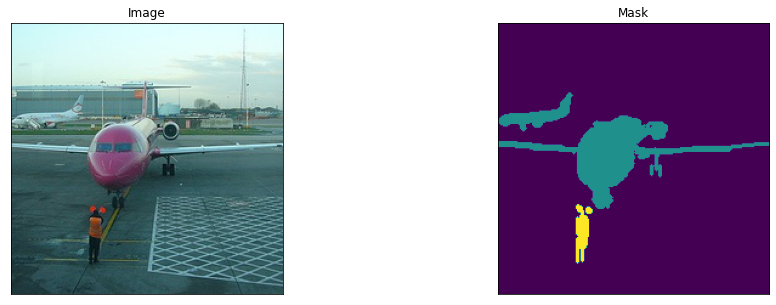

In [246]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['aeroplane', 'person'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[0]
    visualize(
        image=image, 
        mask=np.argmax(mask, axis=2)
     )

## Create model and train

In [255]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [260]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

ENCODER = 'se_resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
           'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
ACTIVATION = 'softmax2d' # could be `sigmoid` for binary class or None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'
BATCH_SIZE=8
EPOCHS = 50

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=n_classes, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [261]:
train_dataset = Dataset(
    train_dir, 
    augmentation=resize(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    valid_dir, 
    augmentation=resize(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=True, num_workers=4)

In [262]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Fscore(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [263]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [264]:
# train model for 40 epochs

max_score = 0

for i in range(0, EPOCHS):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 1449/1449 [00:35<00:00, 40.81it/s, dice_loss - 0.2523, iou_score - 0.6321]
Model saved!

Epoch: 1
valid: 100%|██████████| 1449/1449 [00:34<00:00, 41.77it/s, dice_loss - 0.2523, iou_score - 0.6321]
Model saved!

Epoch: 2
valid: 100%|██████████| 1449/1449 [00:34<00:00, 42.12it/s, dice_loss - 0.2523, iou_score - 0.6321]
Model saved!

Epoch: 3
valid: 100%|██████████| 1449/1449 [00:34<00:00, 41.68it/s, dice_loss - 0.2523, iou_score - 0.6321]

Epoch: 4
valid: 100%|██████████| 1449/1449 [00:34<00:00, 42.23it/s, dice_loss - 0.2523, iou_score - 0.6321]

Epoch: 5
valid: 100%|██████████| 1449/1449 [00:34<00:00, 42.05it/s, dice_loss - 0.2523, iou_score - 0.6321]

Epoch: 6
valid: 100%|██████████| 1449/1449 [00:34<00:00, 42.02it/s, dice_loss - 0.2523, iou_score - 0.6321]
Model saved!

Epoch: 7
valid: 100%|██████████| 1449/1449 [00:34<00:00, 42.18it/s, dice_loss - 0.2523, iou_score - 0.6321]

Epoch: 8
valid: 100%|██████████| 1449/1449 [00:34<00:00, 41.93it/s, dice_lo

## Test best saved model

In [265]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [266]:
# create test dataset
test_dataset = Dataset(
    test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [267]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 199/199 [00:10<00:00, 18.82it/s, dice_loss - 0.4183, iou_score - 0.4779]


## Visualize predictions

In [273]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    test_dir, 
    classes=CLASSES,
)

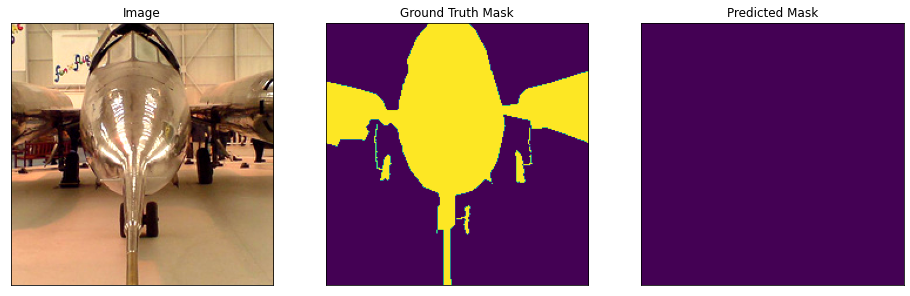

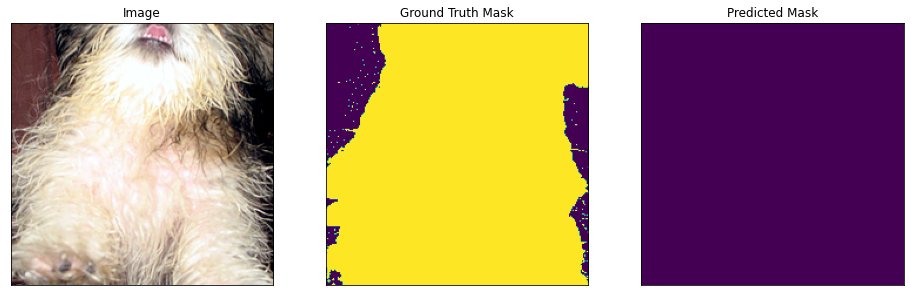

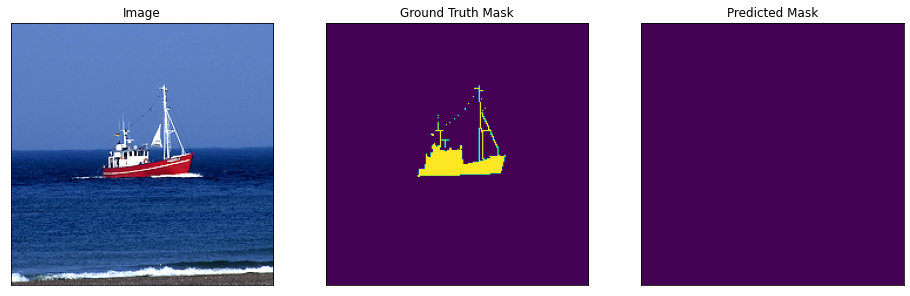

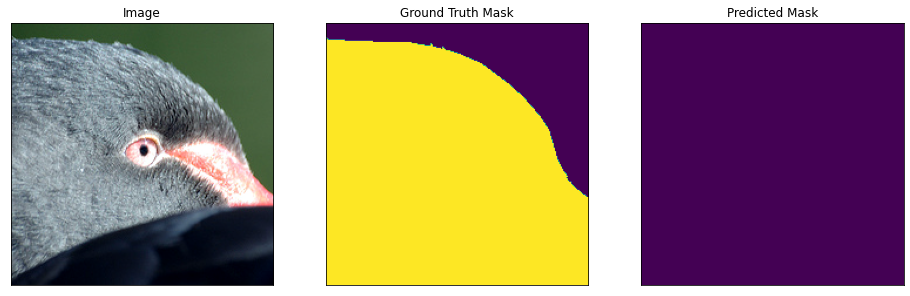

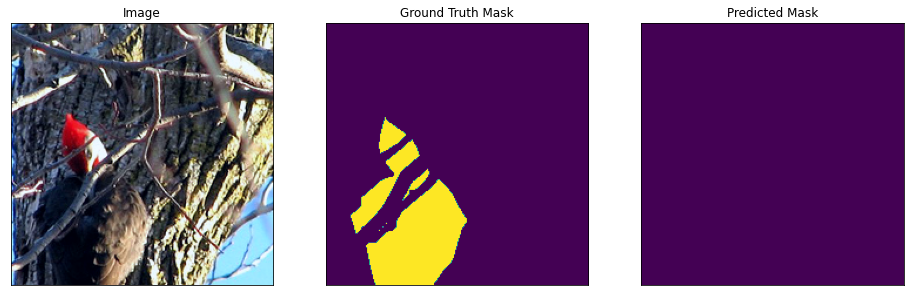

In [274]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=denormalize(image.transpose(1, 2, 0)), 
        ground_truth_mask=np.argmax(gt_mask, axis=0), 
        predicted_mask=np.argmax(pr_mask, axis=0)
    )